In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
sns.set()
sns.set(rc={'figure.figsize':(25, 10)})
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Preprocess data

In [ ]:
url = 'http://lennuki.myqnapcloud.com:8080/share.cgi?ssid=02mwhAw&fid=02mwhAw&filename=el.xlsx&openfolder=forcedownload&ep='
data_df = pd.read_excel(url,  header=1)
data_df = data_df.iloc[12456:82584] #from 2013 we have hourly data, drop rows before that. Drop values of year 2021
data_df.drop(data_df.columns[[2,3]],axis=1,inplace=True) #drop cols where there is no needed information
data_df.reset_index(inplace=True, drop=True)

date_info_df = data_df["Tund"].str.split(" ", expand = True)
data_df['Date']= date_info_df[0] 
data_df['Hour']= date_info_df[2] 
data_df['Weekday']= date_info_df[1]

#Merge columns to convert it to datetime
data_df["Datetime"] = data_df['Date'] + ' ' + data_df['Hour']
data_df.drop(data_df.columns[[0,3]],axis=1,inplace=True)

#Covert to datetime
data_df['Datetime']=pd.to_datetime(data_df['Datetime'], format='%d.%m.%Y %H:%M')
data_df['Date']=pd.to_datetime(data_df['Date'], format='%d.%m.%Y')
data_df['Date']=data_df['Date'].dt.strftime('%Y-%m-%d')
#Convert hour to numeric
data_df['Hour'] = data_df['Datetime'].dt.strftime('%H')
data_df['Hour'] = pd.to_numeric(data_df['Hour'])


#Add weekend information

holidays = ['01-01', '02-24', '05-01', '06-23', '06-24', '08-20', '12-24', '12-25', '12-26']

#suur reede, ülestõusmispüha 1 püha, nelipüha
moving_holidays = ['2013-03-29','2014-04-18','2015-04-03','2016-03-25','2017-04-14','2018-03-30','2019-04-19','2020-04-10',
                   '2013-03-31','2014-04-20','2015-04-05','2016-03-27', '2017-04-16','2018-04-01','2019-04-21','2020-04-12',
                   '2013-05-19','2014-06-08','2015-05-24','2016-05-15', '2017-06-04', '2018-05-20','2019-06-09', '2020-05-31']


weekend_conditions = [(data_df['Weekday'] == 'L'), (data_df['Weekday'] == 'P'), (data_df['Datetime'].dt.strftime('%m-%d').isin(holidays)),
                                                                                 (data_df['Datetime'].dt.strftime('%Y-%m-%d').isin(moving_holidays))] #L is Saturday and P is Sunday
weekend_values = [1, 1, 1, 1]

data_df['Weekend'] = np.select(weekend_conditions, weekend_values, default = 0)

#Add season(winter, spring, summer, autumn) information based on month
data_df['Month'] = data_df['Datetime'].dt.strftime('%m')
data_df['Month'] = pd.to_numeric(data_df['Month'])
season_conditions = [(data_df['Month'] <= 3), 
                    (data_df['Month'] >= 4)  & (data_df['Month'] <= 6),
                    (data_df['Month'] >= 7)  & (data_df['Month'] <= 9),
                    (data_df['Month'] >= 10)  & (data_df['Month'] <= 12)]
season_values = [ 'Winter', 'Spring', 'Summer', 'Autumn']
data_df['Season'] = np.select(season_conditions, season_values)

data_df['Year'] = data_df['Datetime'].dt.strftime('%Y')
data_df['Datetime2'] = data_df['Datetime']

# Set date column as index 
index_data = data_df.set_index('Datetime')

index_data['Day_of_year'] = index_data.index.dayofyear
index_data['Week_nr'] = index_data.index.week

#I will use only data from 2017
index_data = index_data.loc['20170101':] 

#Remove 0 values
index_data.at['2019-04-05 10:00:00', 'Tarbimine'] = index_data.loc['2019-04-05 09:00:00']['Tarbimine']
index_data.at['2019-04-05 11:00:00', 'Tarbimine'] = index_data.loc['2019-04-05 09:00:00']['Tarbimine']
index_data.at['2019-11-26 10:00:00', 'Tarbimine'] = index_data.loc['2019-11-26 09:00:00']['Tarbimine']
index_data.at['2019-11-26 11:00:00', 'Tarbimine'] = index_data.loc['2019-11-26 09:00:00']['Tarbimine']

# Daylight duaration



In [ ]:
#Add daylight information
daylight_url = 'http://lennuki.myqnapcloud.com:8080/share.cgi?ssid=0j0PWw1&fid=0j0PWw1&filename=day_length.csv&openfolder=forcedownload&ep='
daylight_df = pd.read_csv(daylight_url)
index_data = pd.merge(index_data, daylight_df, on='Date')
index_data = index_data.set_index('Datetime2')
index_data.index.names = ['Datetime']

# Weather data




In [ ]:
weather_url = 'http://lennuki.myqnapcloud.com:8080/share.cgi?ssid=0yXvbsD&fid=0yXvbsD&filename=harku_ilmaandmed.xlsx&openfolder=forcedownload&ep='
weather_df = pd.read_excel(weather_url,  header=2)

#Take hour from object
weather_df['Kell (UTC)'] = weather_df['Kell (UTC)'].astype(str).str[:2]

weather_df.rename(columns={'Aasta': 'year', 'Kuu': 'month', 'Päev':'day', 'Kell (UTC)':'hour'}, inplace=True)

weather_df.dropna(thresh=7, inplace=True) #After 23 there were empty rows

weather_df['hour'] = pd.to_numeric(weather_df['hour'])

weather_df.drop(['Tunni atmosfääri nähtus'], axis=1, inplace=True)

weather_df["Datetime"] = pd.to_datetime(weather_df[['year', 'month', 'day', 'hour']])

weather_df.drop(weather_df.columns[[0, 1, 2, 3]],axis=1,inplace=True)

index_weather = weather_df.set_index('Datetime')

index_weather.columns =['avg_hPa', 'precipitations_mm', 'avg_humidity_%', 'avg_temp_C', 'avg_visibility_m', 'avg_wind_direction', 'avg_wind_speed_ms', 'max_wind_speed_ms'] 
index_weather.fillna(method='ffill', inplace=True)

In [ ]:
electricity_weather_df = pd.merge(index_data, index_weather, left_index=True, right_index=True)
electricity_weather_df.drop(['Date', 'Year', 'Day_of_year','Week_nr', 'Month'], axis=1, inplace=True)
electricity_weather_df_dummies = pd.get_dummies(electricity_weather_df, columns=['Season', 'Hour', 'Weekday'],  dtype=int)

data_with_important_weather_variables = electricity_weather_df_dummies.copy()
data_with_important_weather_variables.drop(['precipitations_mm', 'avg_wind_speed_ms', 'max_wind_speed_ms', 'avg_visibility_m', 'avg_wind_direction', 'avg_hPa'], axis=1, inplace=True)

In [ ]:
data_with_important_weather_variables.head()

In [ ]:
#Transform consumption to log scale
data_with_important_weather_variables['Tarbimine'] = np.log(data_with_important_weather_variables['Tarbimine'])

# Create dataset

In [ ]:
train_LSTM = data_with_important_weather_variables[:'2019']
test_LSTM = data_with_important_weather_variables['2020']

In [ ]:
feature_columns = ['Weekend', 'day_length', 'avg_humidity_%', 'avg_temp_C',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
       'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Weekday_E',
       'Weekday_K', 'Weekday_L', 'Weekday_N', 'Weekday_P', 'Weekday_R',
       'Weekday_T']

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)-2].values  #ei võeta sisse t, t-1 ja t-2
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# LSTM

## Transform data

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
feature_transformer_LSTM = MinMaxScaler()
consumption_transformer_LSTM = MinMaxScaler()

feature_transformer_LSTM = feature_transformer_LSTM.fit(train_LSTM[feature_columns].to_numpy())
consumption_transformer_LSTM = consumption_transformer_LSTM.fit(train_LSTM[['Tarbimine']])

train_LSTM.loc[:, feature_columns] = feature_transformer_LSTM.transform(train_LSTM[feature_columns].to_numpy())
train_LSTM['Tarbimine'] = consumption_transformer_LSTM.transform(train_LSTM[['Tarbimine']])

test_LSTM.loc[:, feature_columns] = feature_transformer_LSTM.transform(test_LSTM[feature_columns].to_numpy())
test_LSTM['Tarbimine'] = consumption_transformer_LSTM.transform(test_LSTM[['Tarbimine']])

In [ ]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train_LSTM, y_train_LSTM = create_dataset(train_LSTM, train_LSTM.Tarbimine, time_steps) 
X_test_LSTM, y_test_LSTM = create_dataset(test_LSTM, test_LSTM.Tarbimine, time_steps)

print(X_train_LSTM.shape, y_train_LSTM.shape)

(26256, 22, 40) (26256,)


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dropout, Dense, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Tuning

In [ ]:
pip install -q -U keras-tuner


In [ ]:
import kerastuner as kt

In [ ]:
#https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder(hp):
  model = keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=hp_units, 
        input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]),
      )
    )
  )

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_loss', direction="min"),
                     max_epochs=50,  directory='tuning_log')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner.search(
    X_train_LSTM, 
    y_train_LSTM, 
    epochs=50, 
    callbacks=[stop_early], 
    batch_size=64, 
    validation_split=0.15,
    shuffle=False)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

## Real model

In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=256, 
      input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001)) 

In [ ]:
history = model.fit(
    X_train_LSTM, y_train_LSTM, 
    epochs=30, 
    batch_size=64, 
    validation_split=0.15,
    shuffle=False
)

In [ ]:
sns.set(rc={'figure.figsize':(25, 10)})
plt.figure(figsize=(11, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Kadu (loss)')
plt.xlabel('Epohhide arv')
plt.legend();

In [ ]:
y_pred_LSTM = model.predict(X_test_LSTM)

In [ ]:
y_test_inverse_LSTM =  np.exp(consumption_transformer_LSTM.inverse_transform(y_test_LSTM.reshape(1, -1)))
y_pred_inverse_LSTM =  np.exp(consumption_transformer_LSTM.inverse_transform(y_pred_LSTM))

## Results

In [ ]:
# RMSE
rmse_LSTM = sqrt(mean_squared_error(y_test_inverse_LSTM.flatten(), y_pred_inverse_LSTM.flatten()))
print('Test RMSE: %.2f' % rmse_LSTM) 

mape_LSTM = mean_absolute_percentage_error(y_test_inverse_LSTM.flatten(), y_pred_inverse_LSTM.flatten())
print('Test MAPE: %.2f' % mape_LSTM) 

#R^2
lstm_score = r2_score(y_test_inverse_LSTM.flatten(), y_pred_inverse_LSTM.flatten())
print('Test R^2: %.2f' % lstm_score)

Test RMSE: 0.92
Test MAPE: 40.27
Test R^2: 0.63


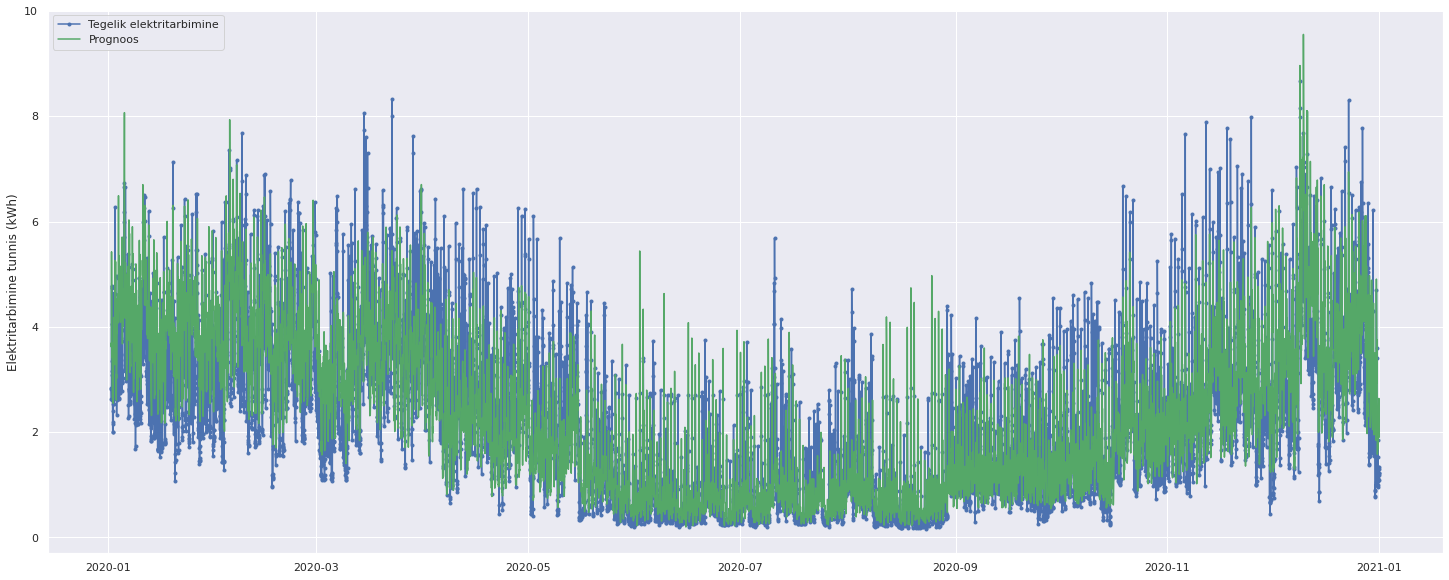

In [ ]:
plt.plot(data_with_important_weather_variables['2020-01-02':].index, y_test_inverse_LSTM.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(data_with_important_weather_variables['2020-01-02':].index, y_pred_inverse_LSTM.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlabel('')
plt.legend()
plt.show();

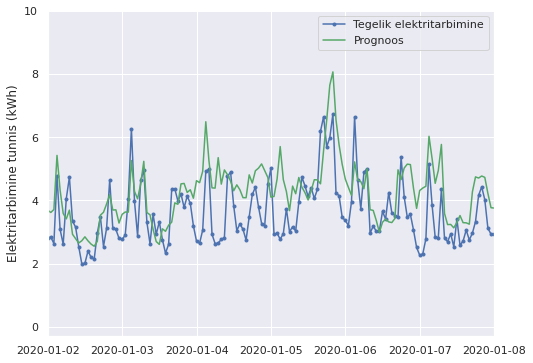

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(data_with_important_weather_variables['2020-01-02':].index, y_test_inverse_LSTM.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(data_with_important_weather_variables['2020-01-02':].index, y_pred_inverse_LSTM.flatten(), 'g', label="Prognoos")
plt.xlim(pd.Timestamp('2020-01-02'), pd.Timestamp('2020-01-08'))
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlabel('')
plt.legend()
plt.show();

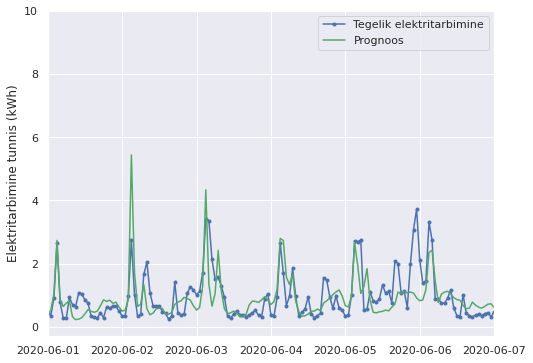

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(data_with_important_weather_variables['2020-01-02':].index, y_test_inverse_LSTM.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(data_with_important_weather_variables['2020-01-02':].index, y_pred_inverse_LSTM.flatten(), 'g', label="Prognoos")
plt.xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2020-06-7'))
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlabel('')
plt.legend()
plt.show();

# LSTM one month

In [ ]:
time_steps = 24

feature_transformer_LSTM_2 = MinMaxScaler()
consumption_transformer_LSTM_2 = MinMaxScaler()

train_LSTM_2 = data_with_important_weather_variables[:'2020-11']
test_LSTM_2 = data_with_important_weather_variables['2020-12']

X_train_LSTM_2, y_train_LSTM_2 = create_dataset(train_LSTM, train_LSTM.Tarbimine, time_steps) 
X_test_LSTM_2, y_test_LSTM_2 = create_dataset(test_LSTM, test_LSTM.Tarbimine, time_steps)

feature_transformer_LSTM_2 = feature_transformer_LSTM_2.fit(train_LSTM_2[feature_columns].to_numpy())
consumption_transformer_LSTM_2 = consumption_transformer_LSTM_2.fit(train_LSTM_2[['Tarbimine']])

train_LSTM_2.loc[:, feature_columns] = feature_transformer_LSTM_2.transform(train_LSTM_2[feature_columns].to_numpy())
train_LSTM_2['Tarbimine'] = consumption_transformer_LSTM_2.transform(train_LSTM_2[['Tarbimine']])

test_LSTM_2.loc[:, feature_columns] = feature_transformer_LSTM_2.transform(test_LSTM_2[feature_columns].to_numpy())
test_LSTM_2['Tarbimine'] = consumption_transformer_LSTM_2.transform(test_LSTM_2[['Tarbimine']])



In [ ]:
history2 = model.fit(
    X_train_LSTM_2, y_train_LSTM_2, 
    epochs=30, 
    batch_size=64, 
    validation_split=0.15,
    shuffle=False
)

In [ ]:
y_pred_LSTM_2 = model.predict(X_test_LSTM_2)

In [ ]:
y_test_inverse_LSTM_2 =  np.exp(consumption_transformer_LSTM_2.inverse_transform(y_test_LSTM_2.reshape(1, -1)))
y_pred_inverse_LSTM_2 =  np.exp(consumption_transformer_LSTM_2.inverse_transform(y_pred_LSTM_2))

In [ ]:
# RMSE
rmse_LSTM_2 = sqrt(mean_squared_error(y_test_inverse_LSTM_2.flatten(), y_pred_inverse_LSTM_2.flatten()))
print('Test RMSE: %.2f' % rmse_LSTM_2) 

mape_LSTM_2 = mean_absolute_percentage_error(y_test_inverse_LSTM_2.flatten(), y_pred_inverse_LSTM_2.flatten())
print('Test MAPE: %.2f' % mape_LSTM_2) 

#R^2
lstm_score_2 = r2_score(y_test_inverse_LSTM_2.flatten(), y_pred_inverse_LSTM_2.flatten())
print('Test R^2: %.2f' % lstm_score_2)

Test RMSE: 0.91
Test MAPE: 40.62
Test R^2: 0.63


# Add lags to data

In [ ]:
df_lagged_data = data_with_important_weather_variables['Tarbimine'].copy()
window_size = 24

for window in range(1, window_size + 1):
    shifted = data_with_important_weather_variables['Tarbimine'].shift(window)
    
    df_lagged_data = pd.concat((df_lagged_data, shifted), axis=1)
df_lagged_data.columns = ['Tarbimine2', 't-1', 't-2','t-3','t-4','t-5','t-6',
                          't-7','t-8','t-9','t-10','t-11','t-12','t-13','t-14',
                          't-15','t-16','t-17','t-18','t-19','t-20','t-21',
                          't-22','t-23','t-24']



In [ ]:
df_lagged_data.head(n=25)

In [ ]:
electricity_data = data_with_important_weather_variables.merge(df_lagged_data, how='right', left_index=True, right_index = True)
electricity_data.drop(['Tarbimine2', 't-1','t-2'], axis=1, inplace=True)


In [ ]:
electricity_data = electricity_data.dropna()
electricity_data.head()

# SVR 



In [ ]:
from sklearn.svm import SVR
from sklearn import svm

## Transform data

In [ ]:
X_train_SVR = electricity_data[:'2019'].drop(['Tarbimine'], axis = 1)
y_train_SVR = electricity_data[:'2019'][['Tarbimine']]
X_test_SVR = electricity_data['2020'].drop(['Tarbimine'], axis = 1)
y_test_SVR = electricity_data['2020'][['Tarbimine']]

In [ ]:
feature_transformer_SVR = MinMaxScaler()
consumption_transformer_SVR = MinMaxScaler()
X_train_SVR = feature_transformer_SVR.fit_transform(X_train_SVR)
y_train_SVR = consumption_transformer_SVR.fit_transform(y_train_SVR)
X_test_SVR = feature_transformer_SVR.fit_transform(X_test_SVR)
y_test_SVR = consumption_transformer_SVR.fit_transform(y_test_SVR)

## Tuning

### Best kernel

In [ ]:
for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train_SVR, y_train_SVR.ravel())
    confidence = clf.score(X_train_SVR, y_train_SVR.ravel())
    print(k,confidence)

### Gridsearch

In [ ]:
# Parameter grid for the Grid Search
param_grid_SVR = {'C': [0.01,0.1,1, 10], 'epsilon': [10,1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

tscv = TimeSeriesSplit(n_splits=3)

grid_SVR = GridSearchCV(SVR(), param_grid_SVR, refit=True, verbose=0, cv=tscv)
grid_SVR.fit(X_train_SVR, y_train_SVR.ravel())

In [ ]:
print('Best parameters obtained by Grid Search:', grid_SVR.best_params_)

## Model

In [ ]:
svr_rbf=SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.01)
#svr_rbf=SVR(kernel='rbf', C=0.1, gamma='auto', epsilon=0.0001)

In [ ]:
SVR_model = svr_rbf.fit(X_train_SVR, y_train_SVR)

In [ ]:
y_pred_SVR = SVR_model.predict(X_test_SVR)

In [ ]:
y_test_inverse_SVR = np.exp(consumption_transformer_SVR.inverse_transform(y_test_SVR.reshape(1, -1)))
y_pred_inverse_SVR = np.exp(consumption_transformer_SVR.inverse_transform(y_pred_SVR.reshape(1, -1)))

## Results

In [ ]:
# RMSE
rmse_SVR = sqrt(mean_squared_error(y_test_inverse_SVR.flatten(), y_pred_inverse_SVR.flatten()))
print('Test RMSE: %.2f' % rmse_SVR) #Test RMSE: 0.736

mape_SVR = mean_absolute_percentage_error(y_test_inverse_SVR.flatten(), y_pred_inverse_SVR.flatten())
print('Test MAPE: %.2f' % mape_SVR) 

#R^2
score_SVR = r2_score(y_test_inverse_SVR.flatten(), y_pred_inverse_SVR.flatten())
print('Test R^2: %.2f' % score_SVR)


Test RMSE: 0.88
Test MAPE: 33.19
Test R^2: 0.66


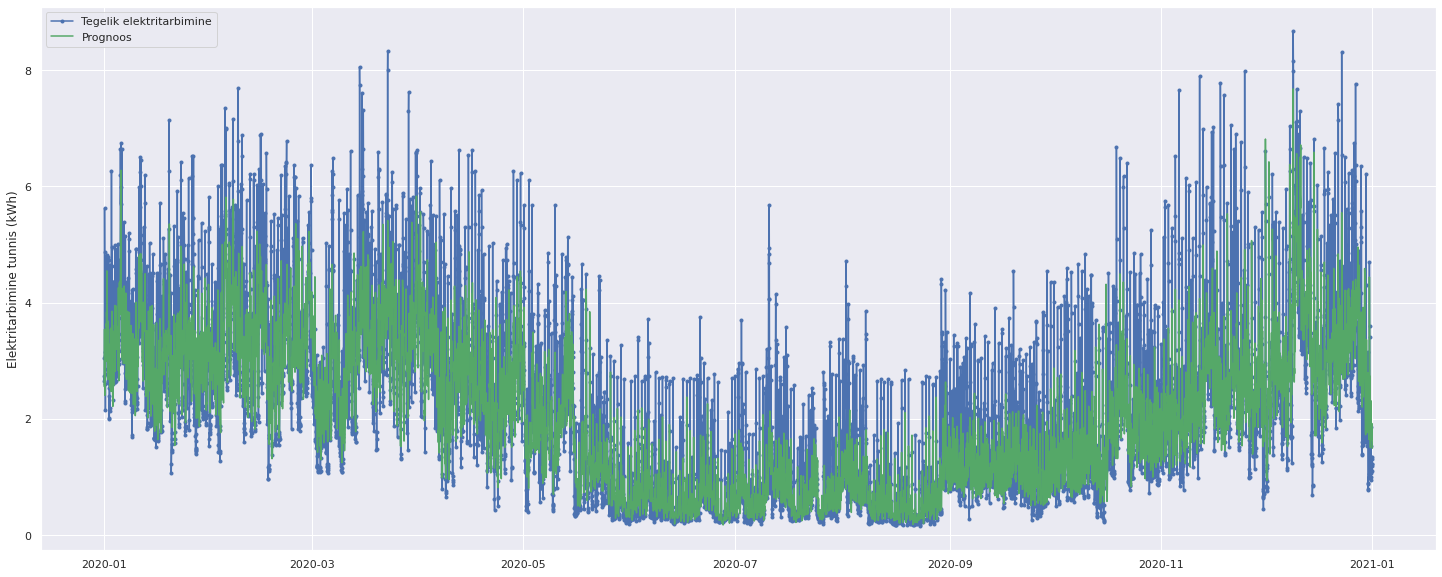

In [ ]:
plt.plot(electricity_data['2020':].index, y_test_inverse_SVR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_SVR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlabel('')
plt.legend()
plt.show();

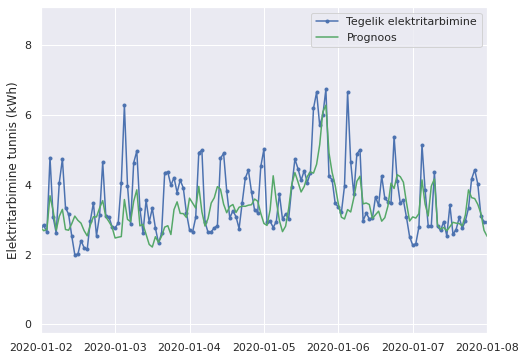

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(electricity_data['2020':].index, y_test_inverse_SVR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_SVR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlim(pd.Timestamp('2020-01-02'), pd.Timestamp('2020-01-08'))
plt.xlabel('')
plt.legend()
plt.show();

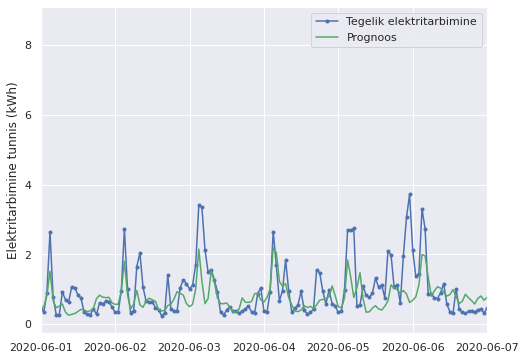

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(electricity_data['2020':].index, y_test_inverse_SVR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_SVR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2020-06-7'))
plt.xlabel('')
plt.legend()
plt.show();

# SVR one week

In [ ]:
X_train_SVR_4 = electricity_data[:'2020-12-13'].drop(['Tarbimine'], axis = 1)
y_train_SVR_4 = electricity_data[:'2020-12-13'][['Tarbimine']]
X_test_SVR_4 = electricity_data['2020-12-14':'2020-12-20'].drop(['Tarbimine'], axis = 1) 
y_test_SVR_4 = electricity_data['2020-12-14':'2020-12-20'][['Tarbimine']]

In [ ]:
feature_transformer_SVR_4= MinMaxScaler()
consumption_transformer_SVR_4 = MinMaxScaler()
X_train_SVR_4 = feature_transformer_SVR_4.fit_transform(X_train_SVR_4)
y_train_SVR_4 = consumption_transformer_SVR_4.fit_transform(y_train_SVR_4)
X_test_SVR_4 = feature_transformer_SVR_4.fit_transform(X_test_SVR_4)
y_test_SVR_4 = consumption_transformer_SVR_4.fit_transform(y_test_SVR_4)

In [ ]:
svr_rbf_4=SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.01)
SVR_model_4 = svr_rbf_4.fit(X_train_SVR_4, y_train_SVR_4)

In [ ]:
y_pred_SVR_4 = SVR_model_4.predict(X_test_SVR_4)

In [ ]:
y_test_inverse_SVR_4 =  np.exp(consumption_transformer_SVR_4.inverse_transform(y_test_SVR_4.reshape(1, -1)))
y_pred_inverse_SVR_4 =  np.exp(consumption_transformer_SVR_4.inverse_transform(y_pred_SVR_4.reshape(1, -1)))

In [ ]:
# RMSE
rmse_SVR_4 = sqrt(mean_squared_error(y_test_inverse_SVR_4.flatten(), y_pred_inverse_SVR_4.flatten()))
print('Test RMSE: %.2f' % rmse_SVR_4) #Test RMSE: 0.736

mape_SVR_4 = mean_absolute_percentage_error(y_test_inverse_SVR_4.flatten(), y_pred_inverse_SVR_4.flatten())
print('Test MAPE: %.2f' % mape_SVR_4) 

#R^2
svr_score_4 = r2_score(y_test_inverse_SVR_4.flatten(), y_pred_inverse_SVR_4.flatten())
print('Test R^2: %.2f' % svr_score_4)

Test RMSE: 1.07
Test MAPE: 28.10
Test R^2: 0.31


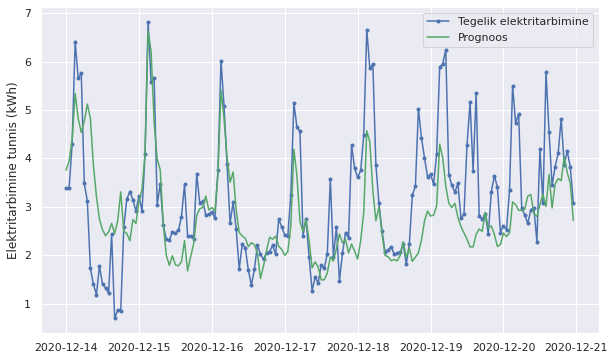

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(electricity_data['2020-12-14':'2020-12-20'].index, y_test_inverse_SVR_4.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020-12-14':'2020-12-20'].index, y_pred_inverse_SVR_4.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlabel('')
plt.legend()
plt.show();

# Linear regression

In [ ]:
from sklearn import linear_model

## Transform data

In [ ]:
X_train_LR = electricity_data[:'2019'].drop(['Tarbimine'], axis = 1)
y_train_LR = electricity_data[:'2019'][['Tarbimine']]
X_test_LR = electricity_data['2020'].drop(['Tarbimine'], axis = 1) 
y_test_LR = electricity_data['2020':][['Tarbimine']]

In [ ]:
feature_transformer_LR= MinMaxScaler()
consumption_transformer_LR = MinMaxScaler()
X_train_LR = feature_transformer_LR.fit_transform(X_train_LR)
y_train_LR = consumption_transformer_LR.fit_transform(y_train_LR)
X_test_LR = feature_transformer_LR.fit_transform(X_test_LR)
y_test_LR = consumption_transformer_LR.fit_transform(y_test_LR)

## Model

In [ ]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train_LR, y_train_LR)

In [ ]:
y_pred_LR = lin_model.predict(X_test_LR)

In [ ]:
y_test_inverse_LR =  np.exp(consumption_transformer_LR.inverse_transform(y_test_LR.reshape(1, -1)))
y_pred_inverse_LR =  np.exp(consumption_transformer_LR.inverse_transform(y_pred_LR.reshape(1, -1)))

## Results

In [ ]:
# RMSE
rmse_LR= sqrt(mean_squared_error(y_test_inverse_LR.flatten(), y_pred_inverse_LR.flatten()))
print('Test RMSE: %.2f' % rmse_LR) 

mape_LR = mean_absolute_percentage_error(y_test_inverse_LR.flatten(), y_pred_inverse_LR.flatten())
print('Test MAPE: %.2f' % mape_LR) 

#R^2
lr_score = r2_score(y_test_inverse_LR.flatten(), y_pred_inverse_LR.flatten())
print('Test R^2: %.2f' % lr_score)

Test RMSE: 0.92
Test MAPE: 35.80
Test R^2: 0.63


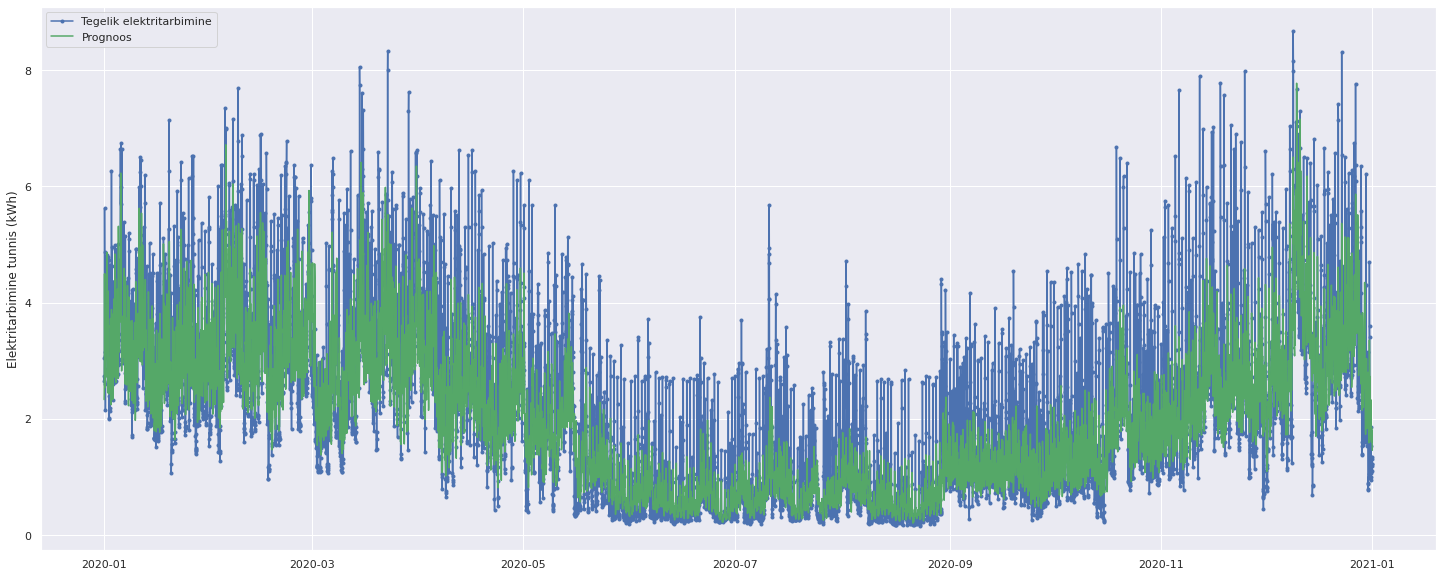

In [ ]:
plt.plot(electricity_data['2020':].index, y_test_inverse_LR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_LR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlabel('')
plt.legend()
plt.show();

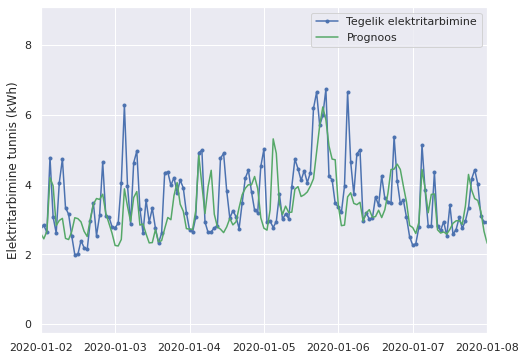

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(electricity_data['2020':].index, y_test_inverse_LR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_LR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlim(pd.Timestamp('2020-01-02'), pd.Timestamp('2020-01-08'))
plt.xlabel('')
plt.legend()
plt.show();

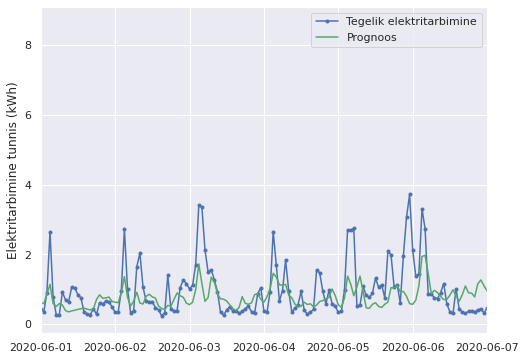

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(electricity_data['2020':].index, y_test_inverse_LR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_LR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2020-06-7'))
plt.xlabel('')
plt.legend()
plt.show();

# XGBoost

## Transform data

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [ ]:
X_train_XGB = electricity_data[:'2019'].drop(['Tarbimine'], axis = 1)
y_train_XGB = electricity_data[:'2019'][['Tarbimine']]
X_test_XGB = electricity_data['2020'].drop(['Tarbimine'], axis = 1) 
y_test_XGB = electricity_data['2020':][['Tarbimine']]

In [ ]:
feature_transformer_XGB= MinMaxScaler()
consumption_transformer_XGB = MinMaxScaler()
X_train_XGB = feature_transformer_XGB.fit_transform(X_train_XGB)
y_train_XGB = consumption_transformer_XGB.fit_transform(y_train_XGB)
X_test_XGB = feature_transformer_XGB.fit_transform(X_test_XGB)
y_test_XGB = consumption_transformer_XGB.fit_transform(y_test_XGB)

## Tuning

### Booster

In [ ]:
for k in ['gbtree', 'gblinear', 'dart']:
    clf = xgb.XGBRegressor(booster=k)
    clf.fit(X_train_XGB, y_train_XGB.ravel())
    confidence = clf.score(X_train_XGB, y_train_XGB.ravel())
    print(k,confidence)

### Gridsearch

In [ ]:
#https://xgboost.readthedocs.io/en/latest/parameter.html
param_grid_XGB =  {
    'booster':['gbtree'],
    'max_depth':[5, 6, 7, 10, 15],
    'min_child_weight': [1,4],
    'eta':[.03, 0.05, .07],
    'subsample': [1],
    'colsample_bytree': [1],
    'objective':['reg:squarederror'],
    'n_estimators': [100, 500],
    'eval_metric':['rmse']
}

tscv = TimeSeriesSplit(n_splits=3)

grid_XGB = GridSearchCV(xgb.XGBRegressor(), param_grid_XGB, refit=True, verbose=0, cv=tscv)


In [ ]:
grid_XGB.fit(X_train_XGB, y_train_XGB.ravel())

In [ ]:
print('Best parameters obtained by Grid Search:', grid_XGB.best_params_)

## Model

In [ ]:
XGB_reg = xgb.XGBRegressor(max_depth = 5, objective='reg:squarederror', eta = 0.03, min_child_weight=4)
XGB_reg.fit(X_train_XGB, y_train_XGB) 

In [ ]:
y_pred_XGB = XGB_reg.predict(X_test_XGB)

In [ ]:
y_test_inverse_XGB =  np.exp(consumption_transformer_XGB.inverse_transform(y_test_XGB.reshape(1, -1)))
y_pred_inverse_XGB =  np.exp(consumption_transformer_XGB.inverse_transform(y_pred_XGB.reshape(1, -1)))

## Results

In [ ]:
# RMSE
rmse_XGB= sqrt(mean_squared_error(y_test_inverse_XGB.flatten(), y_pred_inverse_XGB.flatten()))
print('Test RMSE: %.2f' % rmse_XGB) 

mape_XGB = mean_absolute_percentage_error(y_test_inverse_XGB.flatten(), y_pred_inverse_XGB.flatten())
print('Test MAPE: %.2f' % mape_XGB) 

#R^2
XGB_score = r2_score(y_test_inverse_XGB.flatten(), y_pred_inverse_XGB.flatten())
print('Test R^2: %.2f' % XGB_score)

Test RMSE: 0.91
Test MAPE: 34.22
Test R^2: 0.64


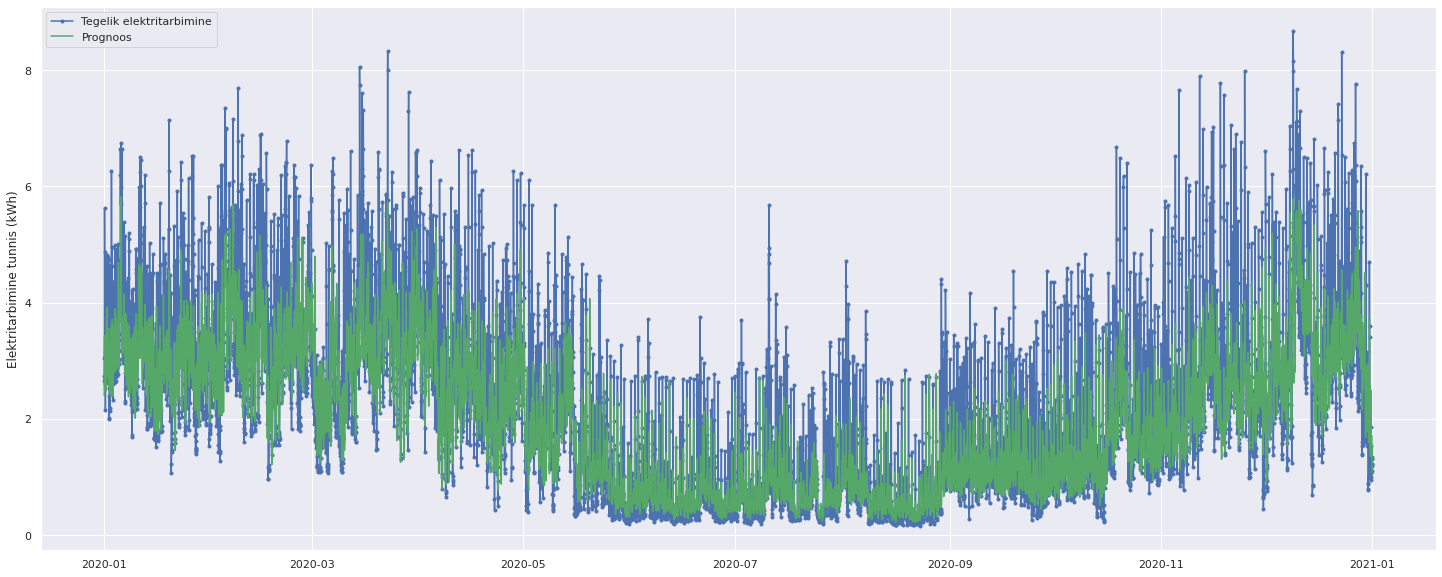

In [ ]:
plt.plot(electricity_data['2020':].index, y_test_inverse_XGB.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_XGB.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlabel('')
plt.legend()
plt.show();

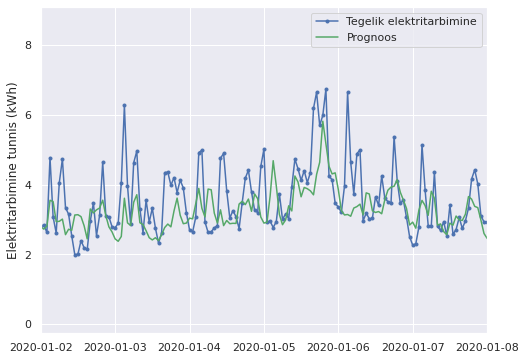

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(electricity_data['2020':].index, y_test_inverse_XGB.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_XGB.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlim(pd.Timestamp('2020-01-02'), pd.Timestamp('2020-01-08'))
plt.xlabel('')
plt.legend()
plt.show();

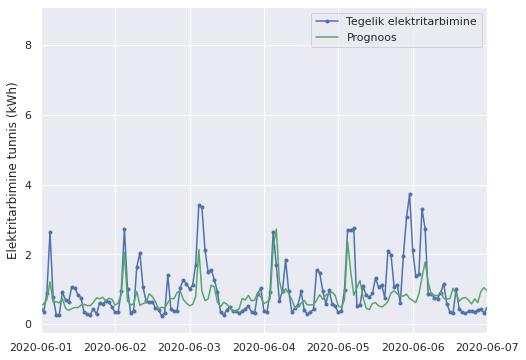

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(electricity_data['2020':].index, y_test_inverse_XGB.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_XGB.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2020-06-7'))
plt.xlabel('')
plt.legend()
plt.show();

# ExtraTreedRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

## Transform data

In [ ]:
X_train_ETR = electricity_data[:'2019'].drop(['Tarbimine'], axis = 1)
y_train_ETR = electricity_data[:'2019'][['Tarbimine']]
X_test_ETR = electricity_data['2020'].drop(['Tarbimine'], axis = 1) 
y_test_ETR = electricity_data['2020':][['Tarbimine']]

In [ ]:
feature_transformer_ETR= MinMaxScaler()
consumption_transformer_ETR = MinMaxScaler()
X_train_ETR = feature_transformer_ETR.fit_transform(X_train_ETR)
y_train_ETR = consumption_transformer_ETR.fit_transform(y_train_ETR)
X_test_ETR = feature_transformer_ETR.fit_transform(X_test_ETR)
y_test_ETR = consumption_transformer_ETR.fit_transform(y_test_ETR)

## Model

In [ ]:
model_ETR = ExtraTreesRegressor(n_estimators=1000,max_depth=20,min_samples_leaf=2)
model_ETR.fit(X_train_ETR, y_train_ETR.ravel())

In [ ]:
y_pred_ETR= model_ETR.predict(X_test_ETR)

In [ ]:
y_test_inverse_ETR =  np.exp(consumption_transformer_ETR.inverse_transform(y_test_ETR.reshape(1, -1)))
y_pred_inverse_ETR =  np.exp(consumption_transformer_ETR.inverse_transform(y_pred_ETR.reshape(1, -1)))

## Results

In [ ]:
# RMSE
rmse_ETR= sqrt(mean_squared_error(y_test_inverse_ETR.flatten(), y_pred_inverse_ETR.flatten()))
print('Test RMSE: %.2f' % rmse_ETR) 

mape_ETR = mean_absolute_percentage_error(y_test_inverse_ETR.flatten(), y_pred_inverse_ETR.flatten())
print('Test MAPE: %.2f' % mape_ETR) 

#R^2
ETR_score = r2_score(y_test_inverse_ETR.flatten(), y_pred_inverse_ETR.flatten())
print('Test R^2: %.2f' % ETR_score)

Test RMSE: 0.90
Test MAPE: 34.34
Test R^2: 0.65


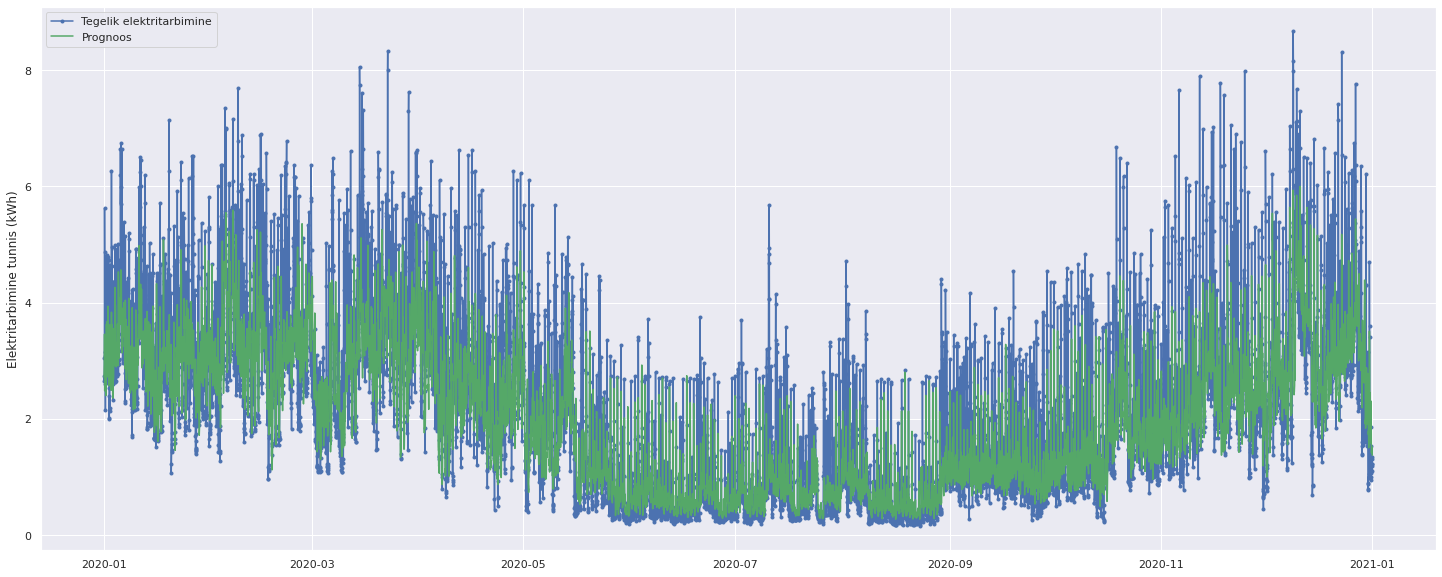

In [ ]:
plt.plot(electricity_data['2020':].index, y_test_inverse_ETR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_ETR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlabel('')
plt.legend()
plt.show();

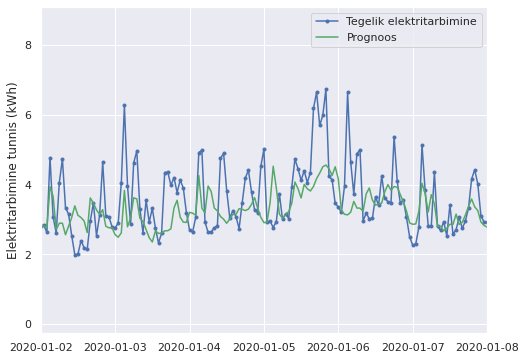

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(electricity_data['2020':].index, y_test_inverse_ETR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_ETR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlim(pd.Timestamp('2020-01-02'), pd.Timestamp('2020-01-08'))
plt.xlabel('')
plt.legend()
plt.show();

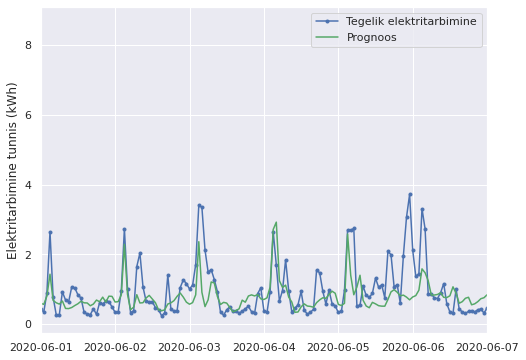

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(electricity_data['2020':].index, y_test_inverse_ETR.flatten(), marker='.', label="Tegelik elektritarbimine")
plt.plot(electricity_data['2020':].index, y_pred_inverse_ETR.flatten(), 'g', label="Prognoos")
plt.ylabel('Elektritarbimine tunnis (kWh)')
plt.xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2020-06-7'))
plt.xlabel('')
plt.legend()
plt.show();